# ABOUT

### F1 Score
* Multilayer models: 0.77290
* FastText: 0.78884
* BERT: 0.76892

# Import

In [1]:
!pip install fasttext
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install transformers
!pip install torchvision

In [2]:
import zipfile
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score

import fasttext

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import keras_core as keras
import keras_nlp
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn import BatchNorm1d
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torch import nn

Using TensorFlow backend


Loading data

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/nlp-getting-started.zip', 'r') as file:
  file.extractall('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/')

In [3]:
data_train = pd.read_csv('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/test.csv')
data_all = pd.concat([data_train, data_test])

In [4]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Target distribution

Text(0, 0.5, 'Count')

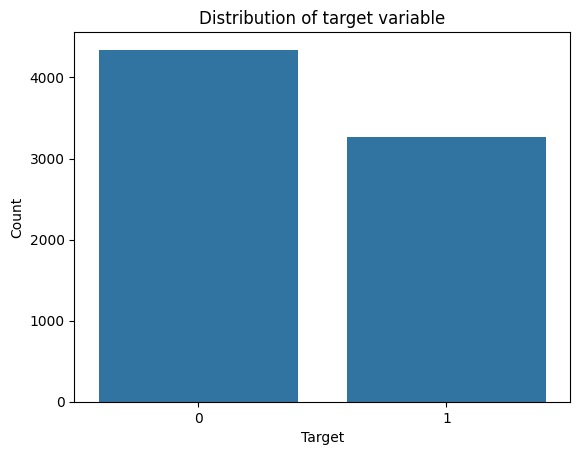

In [ ]:
sns.countplot(data=data_train,
              x='target')
plt.title('Distribution of target variable')
plt.xlabel('Target')
plt.ylabel('Count')

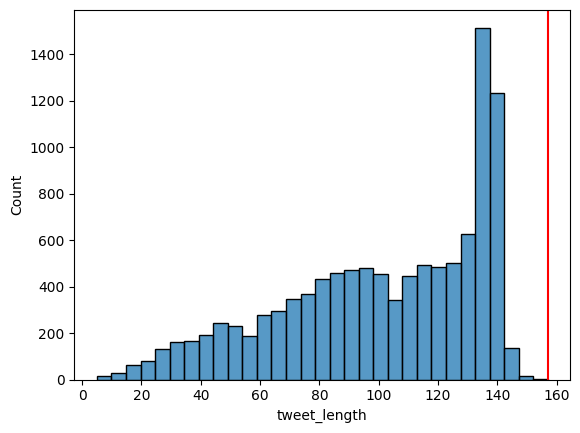

In [ ]:
data_all['tweet_length'] = data_all.text.apply(len)
sns.histplot(data_all['tweet_length'])
plt.axvline(data_all['tweet_length'].max(), c='red')
plt.show()

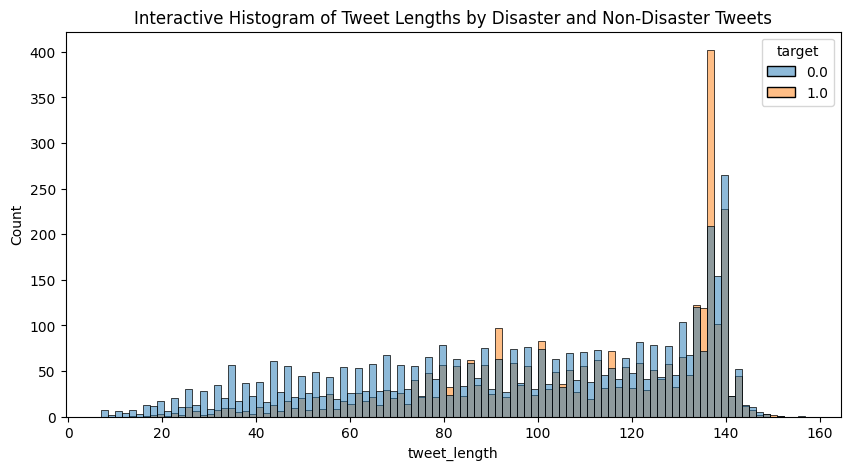

In [ ]:
# compare sentance length based on target
plt.figure(figsize=(10,5))
sns.histplot(
    data=data_all,
    x='tweet_length',
    hue='target',
    bins=100)

plt.title("Interactive Histogram of Tweet Lengths by Disaster and Non-Disaster Tweets")
plt.show()

In [ ]:
# check for missing values
print('Missing values:')
print(data_train.isna().sum())

Missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Clean data using RegEx

In [5]:
def multi_line(text):
    # If there are multiple lines, write them in a single line
    return re.sub(r'\s+', ' ', text.strip())

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) # no emoji

def spec_char(text):
    # Remove special characters, keeping contractions and some symbols
    return re.sub(r"[^\w\s'’—–]", '', text)

def extra_spaces(text):
    # Remove extra spaces from the text
    return re.sub(r' +',' ', text)

def lowered(text):
    # Write the document in lower case
    return text.lower()

def cleaning_text(dataframe_):
    dataframe_['text'] = dataframe_['text'].apply(multi_line)
    dataframe_['text'] = dataframe_['text'].apply(remove_html)
    dataframe_['text'] = dataframe_['text'].apply(remove_url)
    dataframe_['text'] = dataframe_['text'].apply(remove_emoji)
    dataframe_['text'] = dataframe_['text'].apply(spec_char)
    dataframe_['text'] = dataframe_['text'].apply(extra_spaces)
    dataframe_['text'] = dataframe_['text'].apply(lowered)
    return dataframe_['text']

In [6]:
data_train['text'] = cleaning_text(data_train)
data_test['text'] = cleaning_text(data_test)

In [7]:
data_train.text.to_list()[0:5]

['our deeds are the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 "all residents asked to 'shelter in place' are being notified by officers no other evacuation or shelter in place orders are expected",
 '13000 people receive wildfires evacuation orders in california',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into a school']

# FastText

In the sequel, we are going to use only the text and the keyword to classify the tweet. We create a new column 'target_text_keyword' of type str, and of the form '\_\_label__{class} {text} {keyword}', for example

'\_\_label__0 Kaggle is awsome for learning Data Science! Kaggle'

'\_\_label__1 The earthquake killed 200 person. damage'

We create a txt file such that each line in this file contains a tweet with the previous format. This format is requiried by fastText to train the model.

In [10]:
data_train['target_text_keyword'] = '__label__' + data_train.target.astype(str) + ' ' + data_train.text + ' ' + data_train.keyword.apply(lambda x: x if x is not np.NaN else '')

In [11]:
data_train.head()

,id,keyword,location,text,target,target_text_keyword
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,__label__1 our deeds are the reason of this ea...
1,4,NaN,NaN,forest fire near la ronge sask canada,1,__label__1 forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,__label__1 all residents asked to 'shelter in ...
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,__label__1 13000 people receive wildfires evac...
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,__label__1 just got sent this photo from ruby ...


Split and prepare data

In [12]:
train, valid = train_test_split(data_train, test_size=0.2, random_state=123)

#create files for fastText
train.to_csv('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/data_train.train', columns=['target_text_keyword'], index=False, header=False)
valid.to_csv('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/data_train.test', columns=['target_text_keyword'], index=False, header=False)

Training the model

In [13]:
# Creating a training a model using fastText
model_ft = fasttext.train_supervised(input='/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/data_train.train')

# Performance of the model
model_ft.test('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/data_train.test')

(1523, 0.8135259356533159, 0.8135259356533159)

In [14]:
# Using the model to predict wether a tweet is a disaster or not
print(model_ft.predict("Kaggle is awsome for learning Data Science! Kaggle"))
print(model_ft.predict("The earthquake killed 200 person. damage"))

(('__label__0',), array([0.91295803]))
(('__label__1',), array([0.99793911]))


When model.predict is used, it returns a tuple, the first element is the most probable class of the tweet (this is useful when we have more than 3 classes), and the second is the probability of being in that class.

In [15]:
print(model_ft.predict("Kaggle is awsome for learning Data Science! Kaggle",k=2))

(('__label__0', '__label__1'), array([0.91295803, 0.08706199]))


Calculate Precision and Recall scores for Train and Test datasets.

In [16]:
def fasttext_predict_class(dataset):
  predictions_tmp = []
  for row in dataset:
    if model_ft.predict(row)[0][0] == '__label__0':
      predictions_tmp.append(0)  # it is not a disaster
    else:
      predictions_tmp.append(1)  # it is a disaster
  return predictions_tmp

train['fast_predict'] = fasttext_predict_class(train['target_text_keyword'])
valid['fast_predict'] = fasttext_predict_class(valid['target_text_keyword'])

In [20]:
print("FastText Results:")
print(f"Train accuracy: {accuracy_score(train['target'], train['fast_predict']):.4f}, Train precision: {precision_score(train['target'], train['fast_predict']):.4f}, Train recall: {recall_score(train['target'], train['fast_predict']):.4f}")
print(f"Validation accuracy: {accuracy_score(valid['target'], valid['fast_predict']):.4f}, Validation precision: {precision_score(valid['target'], valid['fast_predict']):.4f}, Validation recall: {recall_score(valid['target'], valid['fast_predict']):.4f}")

FastText Results:
Train accuracy: 0.8984, Train precision: 0.9180, Train recall: 0.8394
Validation accuracy: 0.8135, Validation precision: 0.8309, Validation recall: 0.7019


## FastText: Test Dataset

Prepare test dataset

In [ ]:
data_test['target_text_keyword'] = data_test.text + ' ' + data_test.keyword.apply(lambda x: x if x is not np.NaN else '')

In [ ]:
data_to_predict = data_test['target_text_keyword'].values.tolist()

In [ ]:
predictions = []

for sent in data_to_predict:
  if model_ft.predict(sent)[0][0] == '__label__0':
    predictions.append(0)  # it is not a disaster
  else:
    predictions.append(1)  # it is a disaster

In [ ]:
data_test['target_fastText'] = predictions

In [ ]:
data_test.head()

,id,keyword,location,text,target_text_keyword,target
0,0,NaN,NaN,just happened a terrible car crash,just happened a terrible car crash,1
1,2,NaN,NaN,heard about earthquake is different cities sta...,heard about earthquake is different cities sta...,0
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfires,0
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 in china and taiwan,1


# BERT

## BERT Preproccessing

In [21]:
def processing(df):
    df = df.fillna('unknown', axis=1)  # No info
    df['text'] = 'KEYWORD: ' + df.keyword + '; LOCATION: ' + df.location + '; TEXT: ' + df.text
    return df

In [22]:
data_train = processing(data_train)
data_test = processing(data_test)

In [23]:
data_train.head()

,id,keyword,location,text,target,target_text_keyword
0,1,unknown,unknown,KEYWORD: unknown; LOCATION: unknown; TEXT: our...,1,__label__1 our deeds are the reason of this ea...
1,4,unknown,unknown,KEYWORD: unknown; LOCATION: unknown; TEXT: for...,1,__label__1 forest fire near la ronge sask canada
2,5,unknown,unknown,KEYWORD: unknown; LOCATION: unknown; TEXT: all...,1,__label__1 all residents asked to 'shelter in ...
3,6,unknown,unknown,KEYWORD: unknown; LOCATION: unknown; TEXT: 130...,1,__label__1 13000 people receive wildfires evac...
4,7,unknown,unknown,KEYWORD: unknown; LOCATION: unknown; TEXT: jus...,1,__label__1 just got sent this photo from ruby ...


In [24]:
max_length = data_train.text.apply(len).max()

In [25]:
train_x, val_x, train_y, val_y = train_test_split(data_train['text'], data_train['target'], test_size=0.2, random_state=42, stratify=data_train['target'])

Load and apply Tokenizer

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
tokenizer.tokenize("Hello, Iam Yellow 32. Good to know.")

['hello', ',', 'ia', '##m', 'yellow', '32', '.', 'good', 'to', 'know', '.']

In [ ]:
tokenizer.convert_tokens_to_ids(['hello', ',', 'ia', '##m', 'yellow', '32', '.', 'good', 'to', 'know', '.'])

[7592, 1010, 24264, 2213, 3756, 3590, 1012, 2204, 2000, 2113, 1012]

Split records into lists to transform each word separately

In [28]:
tweet_texts_train = list(train_x)
tweet_texts_val = list(val_x)
tweet_texts_test = data_test['text'].tolist()

<b>Padding</b> - technique used to make all sequences in a batch of data have the same length by adding zeros to shorter sequences.

<b>Truncation</b> - truncation should be applied if the input sequences are longer than the specified max_length. Truncation involves cutting off parts of the sequence to fit it into the specified maximum length.

In [29]:
tokenized_tweets_train = tokenizer(tweet_texts_train, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
tokenized_tweets_val = tokenizer(tweet_texts_val, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
tokenized_tweets_test = tokenizer(tweet_texts_test, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

In [ ]:
# See one example
tokenized_tweets_train['input_ids'][0]

tensor([  101,  3145, 18351,  1024,  2510,  1025,  3295,  1024,  3146,  1025,
         3793,  1024, 26103,  1998,  7481,  4106,  1997,  2342,  2000,  2224,
         9593,  5968,  1999,  3386,  1012,  1001, 20168, 19841,  2887,  2510,
         4188,  7806,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

<b>Attention mask</b> - The attention mask is used to indicate which elements in the input sequence should be attended to and which should be ignored. It helps the model focus on relevant parts of the input.

In [30]:
tokenized_tweets_train['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

Transform labels

In [31]:
train_labels = torch.tensor(list(train_y))
val_labels = torch.tensor(list(val_y))

In [ ]:
val_labels

tensor([1, 0, 1,  ..., 1, 1, 0])

<b>TensorDataset</b> - PyTorch utility that creates a dataset by combining tensors along the specified dimension. In our case, it combines the input ids, attention masks, and labels to form a dataset suitable for training a model. Each entry in the dataset will contain the tokenized input, attention mask, and corresponding label for a tweet. Later, it will be pass to DataLoader.

In [32]:
train_dataset = TensorDataset(tokenized_tweets_train['input_ids'], tokenized_tweets_train['attention_mask'], train_labels)
val_dataset = TensorDataset(tokenized_tweets_val['input_ids'], tokenized_tweets_val['attention_mask'], val_labels)
test_dataset = TensorDataset(tokenized_tweets_test['input_ids'], tokenized_tweets_test['attention_mask'])

## Bert Modeling (GPU)

<b>num_labels = 2</b> - the number of labels or classes in the classification task. In this case, the model is configured for binary classification, as indicated by num_labels=2.

<b>num_hidden_layers = 12</b> - parameter determines the number of hidden layers in the BERT model. BERT models consist of a stack of transformer layers, and the number of layers can impact the model's capacity to capture complex patterns in the data.

<b>hidden_size = 768</b> - parameter specifies the dimensionality of the hidden layers in the BERT model. It represents the number of neurons in the hidden layers, and it's a key factor influencing the model's capacity and the number of parameters.

In [33]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2, num_hidden_layers=12, hidden_size=768)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<b>optimizer</b> - updates the model parameters based on the computed gradients during backpropagation.

<b>criterion/loss function</b> - measures the difference between the predicted and actual values during training.

<b>scheduler</b> - learning rate scheduler adjusts the learning rate during training, potentially improving convergence and preventing overshooting (means that the learning rate is too high, and the algorithm jumps over the minimum of the loss function).

<b>AdamW</b> - It is an optimization algorithm, a variant of Adam, that includes weight decay to prevent overfitting.

>{'params': model.bert.parameters(), 'lr': 5e-5}: This specifies the learning rate (5e-5) for the parameters in the BERT model.

>{'params': model.classifier.parameters(), 'lr': 1e-3}: This specifies the learning rate (1e-3) for the parameters in the classification head (classifier).

>lr=5e-6: This sets a default learning rate (5e-6) for parameters not explicitly mentioned in the list.


**criterion** - creates an instance of the cross-entropy loss function. It is commonly used for classification tasks, and it combines the softmax activation and the negative log-likelihood loss.

**StepLR** - This sets up a step learning rate scheduler. It adjusts the learning rate by a factor of gamma every
>step_size=1: The number of epochs after which the learning rate is multiplied by gamma

>gamma=0.1: The factor by which the learning rate is multiplied.

In [34]:
optimizer = torch.optim.AdamW([
    {'params': model.bert.parameters(), 'lr': 5e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], lr=5e-6)
criterion = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

In [35]:
batch_size = 32

In [36]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Fine-tune the model

In [38]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [39]:
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

predictions_tr = []
predictions_val = []

Part for Train data

<b>optimizer.zero_grad()</b> - clears the gradients of all optimized parameters. It's necessary to do this before computing gradients in the backward pass (loss.backward()). Otherwise, the gradient would be a combination of the old gradient, which you have already used to update your model parameters and the newly-computed gradient.

<b>outputs = model(input_ids, attention_mask=attention_mask, labels=labels)</b> - this line computes the forward pass of the model. It generates predictions (outputs) based on the input data.

<b>loss = outputs.loss</b> - This line extracts the loss value from the model's output. The loss is a measure of the difference between the model's predictions and the ground truth labels.

<b>loss.backward()</b> - This line computes the gradients of the model parameters with respect to the loss. These gradients are used to update the model parameters during optimization.

<b>clip_gradnorm(model.parameters(), max_norm=1.0)</b> - It clips the gradients to prevent exploding gradients. The clip_gradnorm function is from PyTorch and
clips gradients to a specified maximum norm (max_norm).

<b>optimizer.step()</b> - This line updates the model parameters based on the computed gradients. The optimizer adjusts the model's parameters to minimize the loss.



Part for Val data

<b>scheduler.step()</b> - The learning rate scheduler adjusts the learning rate based on its defined schedule. For example, it might decrease the learning rate at regular intervals to help the model converge better.

<b>loss = outputs.loss and val_loss += loss.item()</b> - This code computes the forward pass of the model on the validation data and calculates the loss. The loss is accumulated for later reporting.

<b>logits = outputs.logits and preds = torch.argmax(logits, dim=1)</b> - Output logits are obtained from the model, and predictions are made by selecting the class with the highest probability using argmax.

<b>correct_preds += torch.sum(preds == labels).item()</b> - The training progress is printed, showing the current epoch, validation loss, and validation accuracy.

In [40]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    tr_correct_preds = 0
    tr_preds_epoch = []
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        tr_loss = outputs.loss
        train_loss += tr_loss.item()
        tr_loss.backward()

        tr_logits = outputs.logits
        tr_preds = torch.argmax(tr_logits, dim=1)
        tr_correct_preds += torch.sum(tr_preds == labels).item()
        tr_pred_to_labels = tr_preds.cpu().numpy()
        tr_preds_epoch.extend(tr_pred_to_labels)

        if epoch == (num_epochs-1):
          predictions_tr.extend(tr_pred_to_labels)

        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    scheduler.step()

    # Calculate average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = tr_correct_preds / len(train_x)
    train_accuracies.append(train_accuracy)

    f1_tr = f1_score(np.asarray(train_labels.tolist()).reshape(-1,1), tr_preds_epoch)


    model.eval()
    val_loss = 0.0
    correct_preds = 0
    val_preds_epoch = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct_preds += torch.sum(preds == labels).item()
            val_pred_to_labels = preds.cpu().numpy()
            val_preds_epoch.extend(val_pred_to_labels)

            if epoch == (num_epochs-1):
              predictions_val.extend(val_pred_to_labels)

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = correct_preds / len(val_x)
    val_accuracies.append(val_accuracy)

    f1_val = f1_score(np.asarray(val_labels.tolist()).reshape(-1,1), val_preds_epoch)


    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {f1_val:.4f}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Training F1: {f1_tr:.4f}")

Epoch 1/10, Validation Loss: 19.3306, Validation Accuracy: 0.8398, Validation F1: 0.7922, Training Loss: 91.0635, Training Accuracy: 0.7780, Training F1: 0.4056
Epoch 2/10, Validation Loss: 18.3578, Validation Accuracy: 0.8503, Validation F1: 0.8152, Training Loss: 56.6936, Training Accuracy: 0.8869, Training F1: 0.4017
Epoch 3/10, Validation Loss: 19.4720, Validation Accuracy: 0.8398, Validation F1: 0.8106, Training Loss: 48.6972, Training Accuracy: 0.9039, Training F1: 0.3976
Epoch 4/10, Validation Loss: 19.5210, Validation Accuracy: 0.8391, Validation F1: 0.8099, Training Loss: 46.8809, Training Accuracy: 0.9084, Training F1: 0.4082
Epoch 5/10, Validation Loss: 19.5212, Validation Accuracy: 0.8398, Validation F1: 0.8106, Training Loss: 46.9795, Training Accuracy: 0.9103, Training F1: 0.4067
Epoch 6/10, Validation Loss: 19.5214, Validation Accuracy: 0.8398, Validation F1: 0.8106, Training Loss: 47.0389, Training Accuracy: 0.9099, Training F1: 0.3994
Epoch 7/10, Validation Loss: 19.52

Plot training and validation

In [41]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    confusion_mat = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_mat, display_labels=["Not Disaster", "Disaster"])

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    disp.plot()
    disp.ax_.set_title("Precision: " + str(precision.round(2)) + " Recall: " + str(recall.round(2)))


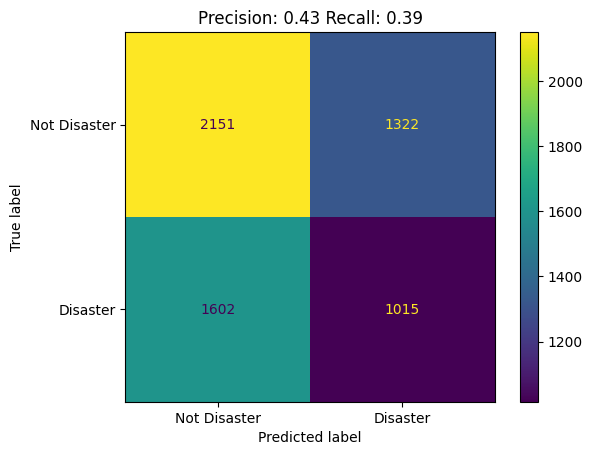

In [42]:
displayConfusionMatrix(np.asarray(train_labels.tolist()).reshape(-1,1), np.asarray(predictions_tr).reshape(-1,1), "Training")

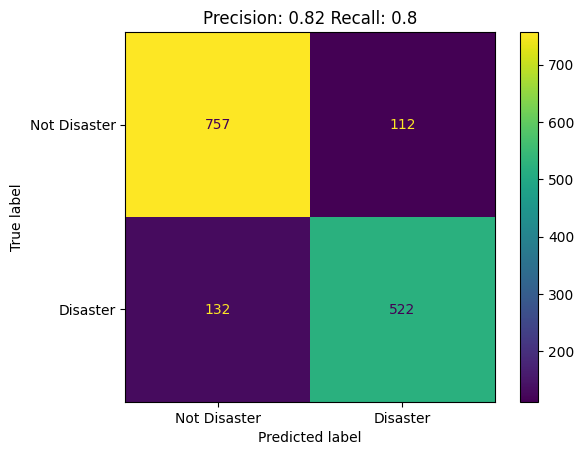

In [43]:
displayConfusionMatrix(np.asarray(val_labels.tolist()).reshape(-1,1), np.asarray(predictions_val).reshape(-1,1), "Training")

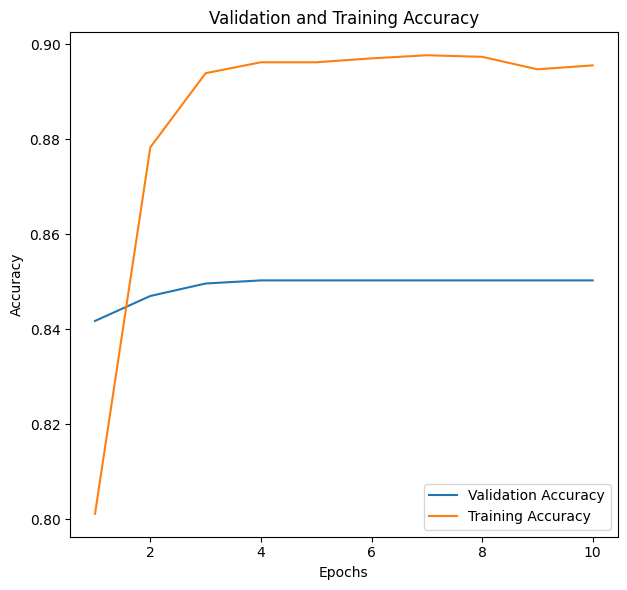

In [ ]:
# Plotting the Validation
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

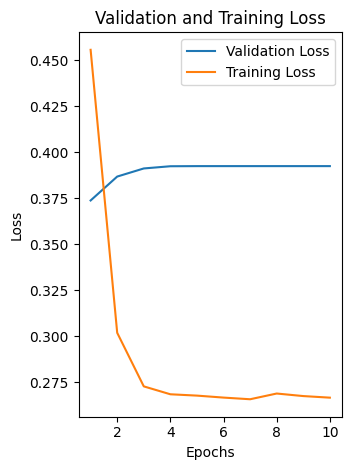

In [ ]:
# Plotting the Training
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Bert: Test Dataset

<b>torch.no_grad()</b> - It disables gradient calculation during model inference. This is done to reduce memory consumption and speed up the process since gradients are not needed during inference/predictions.

<b>preds = torch.argmax(logits, dim=1)</b> - Predicts the class labels by selecting the index with the highest probability using argmax.

<b>preds.cpu().numpy()</b> - converts the predictions from a PyTorch tensor to a NumPy array on the CPU. This is done to facilitate further processing and analysis.

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

1/1 [==============================] - 1s 854ms/step


array([[ 0.0909024 , -0.11707623]], dtype=float32)

# Single layer LSTM

Encoding text

In [41]:
def processing(df):
    df = df.fillna('unknown', axis=1)  # No info
    df['text'] = 'KEYWORD: ' + df.keyword + '; TEXT: ' + df.text  # removed since Location has huge amount of gaps ('; LOCATION: ' + df.location + )
    return df

In [42]:
data_train = processing(data_train)
data_test = processing(data_test)

In [8]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


LSTM models parameters

In [9]:
VOCAB_SIZE = 200000
EMBEDING_DIM = LSTM_DIM = DENSE_DIM = 64
MAX_LEN = data_train.text.apply(len).max()
TRUNC_TYPE = 'post'
OOV_TYPE = '<OOV'

In [10]:
x_train, x_val, y_train, y_val = train_test_split(data_train.text, data_train.target, test_size=0.2, random_state=42, stratify=data_train['target'])

Data Preprocessing

In [11]:
tokenizer = Tokenizer(oov_token=OOV_TYPE)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
print(word_index)

{'<OOV': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'and': 7, 'i': 8, 'is': 9, 'for': 10, 'on': 11, 'you': 12, 'my': 13, 'with': 14, 'it': 15, 'that': 16, 'at': 17, 'by': 18, 'this': 19, 'be': 20, 'from': 21, 'are': 22, 'was': 23, 'have': 24, 'like': 25, 'me': 26, 'just': 27, 'so': 28, 'up': 29, 'but': 30, 'as': 31, 'your': 32, 'not': 33, 'amp': 34, 'out': 35, 'will': 36, 'when': 37, 'all': 38, 'after': 39, 'no': 40, 'has': 41, 'an': 42, 'fire': 43, 'if': 44, 'we': 45, 'get': 46, 'new': 47, "i'm": 48, 'via': 49, 'now': 50, 'about': 51, 'or': 52, 'more': 53, 'news': 54, 'people': 55, 'been': 56, 'what': 57, 'who': 58, 'over': 59, 'one': 60, 'they': 61, "it's": 62, 'into': 63, 'how': 64, 'he': 65, "don't": 66, 'us': 67, 'do': 68, '2': 69, 'video': 70, 'emergency': 71, 'can': 72, 'disaster': 73, 'police': 74, 'her': 75, 'there': 76, 'than': 77, 'still': 78, 'would': 79, 'were': 80, 'some': 81, 'his': 82, 'burning': 83, 'body': 84, 'got': 85, 'back': 86, 'storm': 87, 'rt': 88, 'off': 

In [ ]:
len(word_index)

17422

In [12]:
sequences = tokenizer.texts_to_sequences(x_train)
print(sequences)

[[3888, 178, 324, 832, 3889, 2377, 4, 3890, 1044, 741, 3891, 3892, 3893], [2958, 2959, 5967, 3894, 36, 1610, 59, 38, 55, 11, 2, 928, 39, 416], [5968, 7, 5969, 2960, 22, 3, 1456, 4, 19, 400, 84, 573, 974, 5970], [5971, 975, 25, 3, 448, 119], [285, 1457, 401, 230, 2378, 29, 11, 515, 372, 9, 21, 976, 184], [202, 3, 5972, 119, 3895, 32, 211, 6, 1458, 14, 240, 4, 82, 3896, 7, 100, 10, 174], [742, 3897, 67, 160, 373, 294, 2961, 53, 77, 484, 6, 1611, 11, 109], [3898, 27, 295, 5973, 26, 17, 2, 2379, 7, 27, 402, 10, 69, 1138, 1459], [3899, 96, 1812, 17, 125, 5, 574, 2, 5974, 6, 13, 5975], [57, 264, 73, 22, 12, 37, 12, 46, 743], [5976, 65, 155, 46, 3, 5977, 5978, 6, 3900, 222, 9, 608, 90, 346, 449, 29, 5979], [673, 63, 2, 5980, 5981, 2962, 710, 5982], [48, 2380, 4, 2, 295, 6, 403, 7, 5983, 2, 93, 96, 48, 871, 374, 417, 30, 8, 156, 33, 5984, 418, 13, 609], [60, 1045, 9, 13, 610, 10, 485, 149, 1332, 5985], [5986, 3901, 3902, 222, 5987, 3903, 12, 135, 3904, 1333, 2, 5988, 2381, 6, 5989], [8, 240, 2

In [13]:
padded = pad_sequences(sequences, truncating=TRUNC_TYPE)
print(padded)

[[   0    0    0 ... 3891 3892 3893]
 [   0    0    0 ...  928   39  416]
 [   0    0    0 ...  573  974 5970]
 ...
 [   0    0    0 ... 3842   10 1081]
 [   0    0    0 ... 1171 1238   50]
 [   0    0    0 ...   62   56 3742]]


In [14]:
val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = pad_sequences(val_sequences, truncating=TRUNC_TYPE)

Convert labels to tensors

In [15]:
y_train_tensor = tf.convert_to_tensor(list(y_train))
y_val_tensor = tf.convert_to_tensor(list(y_val))

Modeling

In [51]:
model_single = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_single.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          12800000  
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12874369 (49.11 MB)
Trainable params: 12874369 (49.11 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [52]:
model_single.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [53]:
history = model_single.fit(
    padded,
    y_train_tensor,
    epochs=50,
    validation_data=(val_padded, y_val_tensor)
)

Epoch 1/50
191/191 [==============================] - 41s 197ms/step - loss: 0.5254 - accuracy: 0.7530 - precision_2: 0.7858 - recall_2: 0.5846 - val_loss: 0.4458 - val_accuracy: 0.8043 - val_precision_2: 0.8101 - val_recall_2: 0.7110
Epoch 2/50
191/191 [==============================] - 37s 195ms/step - loss: 0.2344 - accuracy: 0.9144 - precision_2: 0.9212 - recall_2: 0.8758 - val_loss: 0.6173 - val_accuracy: 0.7702 - val_precision_2: 0.7353 - val_recall_2: 0.7263
Epoch 3/50
191/191 [==============================] - 37s 195ms/step - loss: 0.1126 - accuracy: 0.9552 - precision_2: 0.9529 - recall_2: 0.9423 - val_loss: 0.6922 - val_accuracy: 0.7754 - val_precision_2: 0.7653 - val_recall_2: 0.6881
Epoch 4/50
191/191 [==============================] - 38s 198ms/step - loss: 0.0588 - accuracy: 0.9737 - precision_2: 0.9752 - recall_2: 0.9633 - val_loss: 0.9457 - val_accuracy: 0.7249 - val_precision_2: 0.6501 - val_recall_2: 0.7783
Epoch 5/50
191/191 [==============================] - 37s 19

In [56]:
model_single.evaluate(val_padded, y_val_tensor, batch_size=int(1*EMBEDING_DIM))

24/24 [==============================] - 0s 11ms/step - loss: 2.4410 - accuracy: 0.7439 - precision_2: 0.6919 - recall_2: 0.7278


[2.4409782886505127, 0.743926465511322, 0.6918604373931885, 0.7278287410736084]

Single LSTM model results

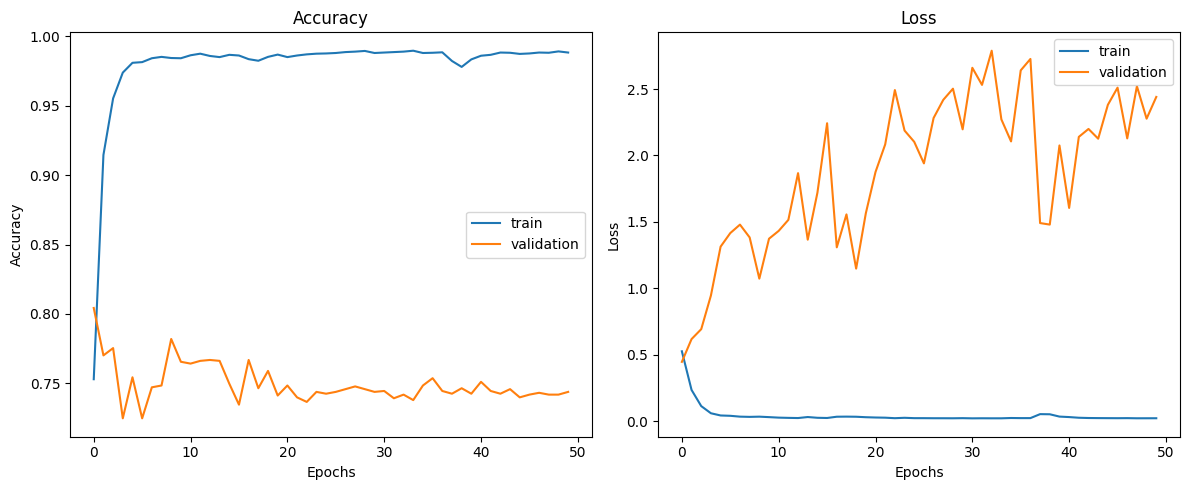

In [57]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['train', 'validation'])
axs[0].set_title('Accuracy')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['train', 'validation'])
axs[1].set_title('Loss')

plt.tight_layout()

# Multi layer LSTM

Preprocessing the same as for single LSTM

Modeling

In [16]:
model_multi = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, int(0.5*EMBEDING_DIM)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(0.5*LSTM_DIM), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(0.5*LSTM_DIM))),
    tf.keras.layers.Dense(int(0.5*DENSE_DIM), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_multi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400000   
                                                                 
 bidirectional (Bidirection  (None, None, 64)          16640     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                        

In [17]:
model_multi.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [18]:
history_1 = model_multi.fit(
    padded,
    y_train_tensor,
    epochs=50,
    validation_data=(val_padded, y_val_tensor)
)

Epoch 1/50
191/191 [==============================] - 58s 179ms/step - loss: 0.6432 - accuracy: 0.6498 - precision: 0.6347 - recall: 0.4356 - val_loss: 0.5980 - val_accuracy: 0.7052 - val_precision: 0.6239 - val_recall: 0.7890
Epoch 2/50
191/191 [==============================] - 30s 159ms/step - loss: 0.5338 - accuracy: 0.7688 - precision: 0.7485 - recall: 0.6958 - val_loss: 0.5851 - val_accuracy: 0.7347 - val_precision: 0.6972 - val_recall: 0.6758
Epoch 3/50
191/191 [==============================] - 31s 161ms/step - loss: 0.4499 - accuracy: 0.8218 - precision: 0.7827 - recall: 0.8105 - val_loss: 0.5343 - val_accuracy: 0.7269 - val_precision: 0.6617 - val_recall: 0.7446
Epoch 4/50
191/191 [==============================] - 31s 161ms/step - loss: 0.4272 - accuracy: 0.8213 - precision: 0.7926 - recall: 0.7914 - val_loss: 0.5340 - val_accuracy: 0.7137 - val_precision: 0.6544 - val_recall: 0.7064
Epoch 5/50
191/191 [==============================] - 30s 157ms/step - loss: 0.3904 - accura

In [19]:
model_multi.evaluate(val_padded, y_val_tensor, batch_size=EMBEDING_DIM)

24/24 [==============================] - 1s 43ms/step - loss: 1.6454 - accuracy: 0.7564 - precision: 0.7461 - recall: 0.6560


[1.6454333066940308,
 0.7564018368721008,
 0.7460869550704956,
 0.6559633016586304]

Result comparison Single vs Multi

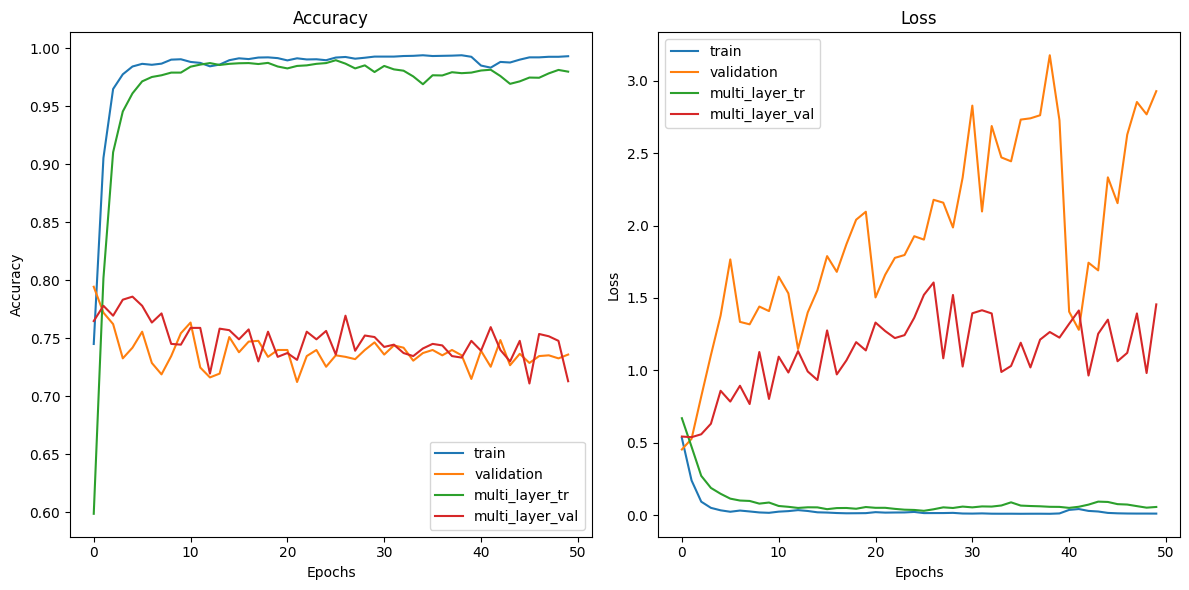

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].plot(history_1.history['accuracy'])
axs[0].plot(history_1.history['val_accuracy'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['train', 'validation', 'multi_layer_tr', 'multi_layer_val'])
axs[0].set_title('Accuracy')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].plot(history_1.history['loss'])
axs[1].plot(history_1.history['val_loss'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['train', 'validation', 'multi_layer_tr', 'multi_layer_val'])
axs[1].set_title('Loss')

plt.tight_layout()